# Assignment 2c Notebook: Competitive Co-Evolution of Pac-Man Controllers and Ghost Controllers
For the final assignment in this course, you will use your cumulative understanding and implementation of genetic programming (GP) to implement the competitive co-evolution of Pac-Man controllers and Ghost controllers! From your previous assignment implementations, copy over the following files:
* base_evolution.py
* fitness.py
* genetic_programming.py (Note: if you haven't already, rename GeneticProgrammingPopulating -> GeneticProgrammingPopulation)
* gpac_population_evaluation.py
* selection.py
* tree_genotype.py

As usual, be careful not to overwrite any of the provided files that may have been modified since previous assignments. To begin the assignment, execute the following cell. **If you implemented your genotype in a new file, be sure to import it in the next cell!**

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from snake_eyes import read_config
from fitness import play_GPac
from selection import *
from genetic_programming import *
from tree_genotype import *
from gpac_population_evaluation import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('The first cell has been executed!')

The first cell has been executed!


## Ghost Controllers
Assuming you already have a working implementation of a GP algorithm for Pac-Man controllers, implementing Ghost controllers should be relatively easy. The only real difference is that, for Ghosts, the G sensor returns the distance to the nearest *other* Ghost, and there is an additional M sensor returning the distance to Pac-Man (or the nearest Pac-Man, if attempting a deliverable with multiple Pac-Man agents in the game). While the algorithms you used to create, reproduce, and evaluate Pac-Man trees should still be applicable here, you need to make sure your code can cleanly handle the different sensor sets. There are many different ways to accomplish that, and it is up to you to choose how.

## Multi-Population Fitness Evaluation
Competitive fitness in GPac has the quirk of only being relative to encountered opponents. Since opponents belong to populations that are evolving, we must re-calculate fitness for all individuals at each generation. Additionally, since it is impracticable to play against all opponents, it is necessary to *approximate* fitness in some way. In practice, you would approximate fitness of an individual through competition with a sample of opponents. In this assignment, however, we allow for each individual to play against only a single opponent per generation to manage computational cost.

**Note**: as mentioned in the assignment description, an individual from a population may have to play multiple games if co-evolving populations are not the same size. See the assignment description for more details.

As a result of the complex nature of competitive fitness for games like GPac, you will typically perform more fitness evaluations per generation than evolution using the same parameters on a problem with an objective/absolute fitness metric. For this assignment, the first generation will require $max(\mu_{PacMan}, \mu_{Ghost})$ fitness evaluations and each subsequent generation will require $max(\mu_{PacMan}+\lambda_{PacMan}, \mu_{Ghost}+\lambda_{Ghost})$ fitness evaluations.

In `gpac_population_evaluation.py`, implement the `competitive_population_evaluation` function that accepts multiple populations as inputs, forms competition match-ups of individuals from the input populations, performs fitness evaluations with the match-ups, and assigns the appropriate fitness values to individuals from the input populations. 

**Note**: the `play_GPac` function returns game score, but Ghost fitness is negated game score plus remaining time (can be found in the last entry in the game log). Recall also that each GP tree should also receive a parsimony penalty.

## Competitive Co-Evolution
Below is a high-level diagram of a 2-population competitive co-evolutionary algorithm. Using your Pac-Man controllers, Ghost controllers, and the `competitive_population_evaluation` function you just implemented, you should have all the necessary components to implement competitive co-evolution!
**Note**: there's a typo in the below figure and both cycles should perform whole-population Competitive Fitness Evaluation instead of evaluating only the children.
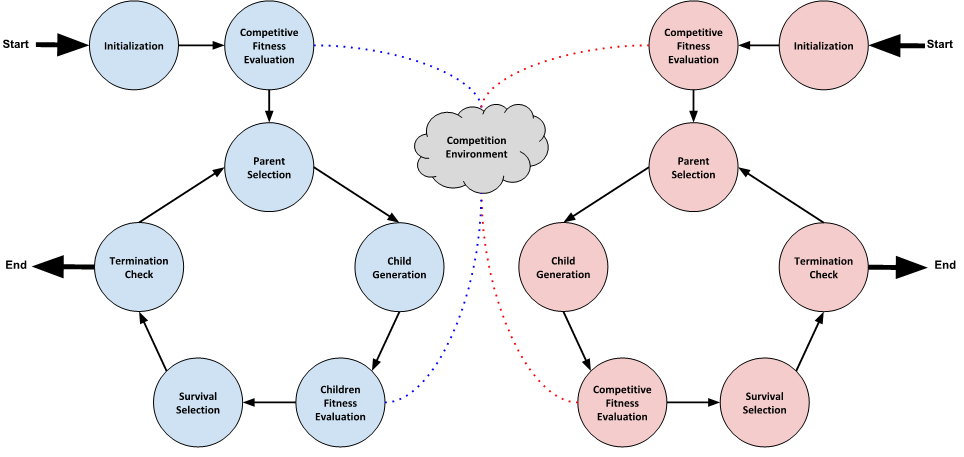

As mentioned previously, the quirks of competitive fitness require that you modify your typical evolution cycles slightly. Namely, you must re-evaluate and recalculate fitness for both populations at each generation. This means that children will be added to the population following child generation and then the *entire* population should be evaluated. Consequently, the number of fitness evaluations per generation varies from previous assignments since individuals from the previous generation are re-evaluated.

### Single Run Experiment
Now that we've covered the quirks of co-evolution a couple times, it's time for you to apply your understanding! In the following cell, implement a single 2,000-fitness-evaluation run of your competitive co-evolutionary algorithm. The config file for co-evolution is a little more complex than previous assignments, so we'll give some code to extract per-species parameters.

In [2]:
from statistics import mean


def competitive_genetic_programming_search(number_evaluations, config_filename):
    config = read_config(config_filename, globalVars=globals(), localVars=locals())
    pac_config = {key.partition('_')[-1]:config[key] for key in config if "pac_" in key}
    ghost_config = {key.partition('_')[-1]:config[key] for key in config if "ghost_" in key}
    
    pacman_evolution = GeneticProgrammingPopulation(**pac_config['EA_configs'], **pac_config, **config)
    ghost_evolution = GeneticProgrammingPopulation(**ghost_config['EA_configs'], **ghost_config, **config, ghost=True)
    
    evaluations = competitive_population_evaluation(
        pacman_evolution.population, ghost_evolution.population, **config['fitness_kwargs']
    )
    
    best_pac = max(pacman_evolution.population, key=lambda x: x.raw_fitness)
    best_ghost = max(ghost_evolution.population, key=lambda x: x.raw_fitness)
    
    data = {
        'pac': {
            'best_fitness': best_pac.raw_fitness,
            'log': best_pac.log,
            'member': best_pac.print(),
            'points': [
                (evaluations, mean(member.raw_fitness for member in pacman_evolution.population), best_pac.raw_fitness)
            ]
        },
        'ghost': {
            'best_fitness': best_ghost.raw_fitness,
            'log': best_ghost.log,
            'member': best_ghost.print(),
            'points': [
                (evaluations, mean(member.raw_fitness for member in ghost_evolution.population), best_ghost.raw_fitness)
            ]
        }
    }
    
    while evaluations < number_evaluations:
        pac_children = pacman_evolution.generate_children()
        ghost_children = ghost_evolution.generate_children()
        
        pacman_evolution.population += pac_children
        ghost_evolution.population += ghost_children
        
        evaluations += competitive_population_evaluation(
            pacman_evolution.population, ghost_evolution.population, **config['fitness_kwargs']
        )
        
        pacman_evolution.survival()
        ghost_evolution.survival()
        
        best_pac = max(best_pac, *pacman_evolution.population, key=lambda x: x.raw_fitness)
        best_ghost = max(best_ghost, *ghost_evolution.population, key=lambda x: x.raw_fitness)
    
        data['pac'].update({
            'best_fitness': best_pac.raw_fitness,
            'log': best_pac.log,
            'member': best_pac.print(),
        })
        data['pac']['points'].append(
            (evaluations, mean(member.raw_fitness for member in pacman_evolution.population), best_pac.raw_fitness)
        )
        
        data['ghost'].update({
            'best_fitness': best_ghost.raw_fitness,
            'log': best_ghost.log,
            'member': best_ghost.print(),
        })
        data['ghost']['points'].append(
            (evaluations, mean(member.raw_fitness for member in ghost_evolution.population), best_ghost.raw_fitness)
        )
    
    data['exhibition'] = play_GPac(best_pac.gene, best_ghost.gene, **config['fitness_kwargs'])
            
    return data

In [3]:
# Test your implementation
data = competitive_genetic_programming_search(750, './configs/green2c_config.txt')

data['pac'].pop('log')
data['ghost'].pop('log')
data.pop('exhibition')

print(data)

{'pac': {'best_fitness': 138, 'member': 'RAND\n|/\n||*\n|||+\n||||+\n|||||W\n|||||G\n||||*\n|||||0.22828242724545866\n|||||F\n|||*\n||||-\n|||||P\n|||||P\n||||RAND\n|||||-5.669626771535555\n|||||F\n||/\n|||*\n||||*\n|||||3.436293070795031\n|||||F\n||||*\n|||||F\n|||||G\n|||RAND\n||||/\n|||||G\n|||||F\n||||-\n|||||W\n|||||G\n|/\n||RAND\n|||-\n||||RAND\n|||||W\n|||||P\n||||*\n|||||G\n|||||P\n|||RAND\n||||*\n|||||P\n|||||-8.618559357714805\n||||-\n|||||-8.574625986583126\n|||||-8.332380395354878\n||RAND\n|||+\n||||RAND\n|||||G\n|||||G\n||||RAND\n|||||F\n|||||W\n|||+\n||||RAND\n|||||F\n|||||W\n||||/\n|||||G\n|||||G', 'points': [(300, 15.28, 103), (750, 22.803333333333335, 138)]}, 'ghost': {'best_fitness': 1333, 'member': '-\n|+\n||*\n|||+\n||||M\n||||W\n|||*\n||||M\n||||-4.59839640360896\n||RAND\n|||-\n||||M\n||||W\n|||+\n||||M\n||||P\n|*\n||-\n|||*\n||||M\n||||M\n|||*\n||||F\n||||P\n||/\n|||RAND\n||||-\n|||||M\n|||||RAND\n||||||M\n||||||W\n||||-1.3775577841014002\n|||-\n||||F\n||||-5.4071

### Multi-Run Experiment
Implement a full 30-run experiment with 2,000 fitness evaluations per run. For each generation, log the average fitness and best fitness of the current population for each species. Average this data across all 30 runs to produce a plot of fitness vs evaluations with average and best fitness averaged across all 30 runs. For each run, log the best fitness of the final population for each species. For the run that produced the highest score in the final generation, play an exhibition game between the highest-fitness Pac-Man controller and Ghost controller from the same run and generation. Save the log from this exhibition game and visualize it for informal analysis in your report. For more detail on report requirements, see the assignment description. While you are not required to rigorously explore different parameters, you are required to utilize configurations that demonstrate a thorough understanding of the parameters' impacts.

In [9]:
from datetime import datetime
from multiprocessing import Pool
import numpy as np
from pathlib import Path
import shutil


NUMBER_OF_CORES = 10


def experiment(runs, evaluations, config_path):
    global run  # used to expose run method to top-level and enable multiprocessing
    
    config_path = Path(config_path)
    config_name = config_path.stem.replace("_config", "")
    data_dir = Path("./data") / config_name
    shutil.rmtree(data_dir, ignore_errors=True)
    
    data_dir.mkdir(exist_ok=True)
    
    # logging file displaying live run progress
    logging_file = open(data_dir / "logging.txt", "w")
    
    def run(i):
        logging_file.write(f"{datetime.now().strftime('%X')} Run {i:2d}: START\n")
        logging_file.flush()
        result = competitive_genetic_programming_search(evaluations, str(config_path))
        logging_file.write(f"{datetime.now().strftime('%X')} Run {i:2d}: ENDED\n")
        logging_file.flush()
        return result

    with Pool(NUMBER_OF_CORES) as p:
        runs = p.map(run, list(range(runs)))

    logging_file.close()
    
    best_run = max((run for run in runs), key=lambda x: x['pac']['best_fitness'])
    
    for species in ('pac', 'ghost'):
    
        with open(data_dir / f'{species}-results.txt', 'w') as f:
            f.write('\n'.join(str(run[species]['best_fitness']) for run in runs))
        
        fig, ax = plt.subplots()
        ax.set_title(f"Per Run {species.title()} Best Fitness")
        ax.set_xlabel("Fitness")
        box_and_whisker = ax.boxplot([run[species]['best_fitness'] for run in runs], vert=False, labels=[""])
        fig.savefig(data_dir / f"{species}-box-and-whisker.png")

        print(f'The fitness of the best {species} is {best_run[species]["best_fitness"]:,}')

        with open(Path('solutions') / f'{species}-{config_name}.txt', 'w') as f:
            f.write(best_run[species]['member'])

        data = [run[species]['points'] for run in runs]

        # log experiment data
        with open(data_dir / f"{species}-data.csv", "w") as data_file:
            data_file.write("run,evaluations,avg_fitness,best_fitness\n")
            for i, datum in enumerate(data):
                for evaluations, avg_fitness, best_fitness in datum:
                    data_file.write(f"{i},{evaluations},{avg_fitness},{best_fitness}\n")

        # per generation box plots (splitting avg & max)
        ticks = []
        avg_fitnesses = []
        max_fitnesses = []
        for i in range(len(data[0])):
            ticks.append(data[0][i][0])
            avg_fitnesses.append([data[j][i][1] for j in range(number_runs)])
            max_fitnesses.append([data[j][i][2] for j in range(number_runs)])

        fig, ax = plt.subplots()
        avg_plot = ax.boxplot(avg_fitnesses, positions=np.array(np.arange(len(avg_fitnesses)))*2.0-0.35, widths=0.75)
        max_plot = ax.boxplot(max_fitnesses, positions=np.array(np.arange(len(max_fitnesses)))*2.0+0.35, widths=0.75)

        def define_box_properties(plot_name, color_code, label):
            for k, v in plot_name.items():
                plt.setp(plot_name.get(k), color=color_code)

            ax.plot([], c=color_code, label=label)
            ax.legend()


        define_box_properties(avg_plot, '#1F77B4', 'avg fitness')
        define_box_properties(max_plot, '#FF7F0E', 'best fitness')

        ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
        ax.set_title(f"Per Generation {species.title()} Avg/Best Fitness")
        ax.set_xlabel("Evaluations")
        ax.set_ylabel("Fitness")
        fig.savefig(data_dir / f"{species}-boxplot.png")
    
    print(f'The fitness of the exhibition is {best_run["exhibition"][0]:,}')
    
    with open(Path('worldFiles') / f'exhibition-{config_name}.txt', 'w') as f:
            [f.write(f'{line}\n') for line in best_run["exhibition"][1]]
    
    del run  # cleanup of global scope abuse
    del define_box_properties  # cleanup of global scope abuse

The fitness of the best pac is 210
The fitness of the best ghost is 1,338
The fitness of the exhibition is 193


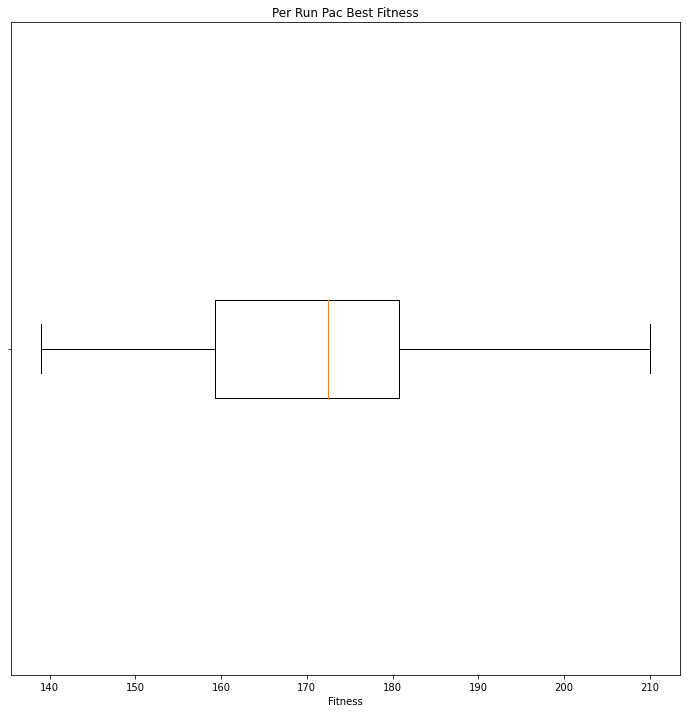

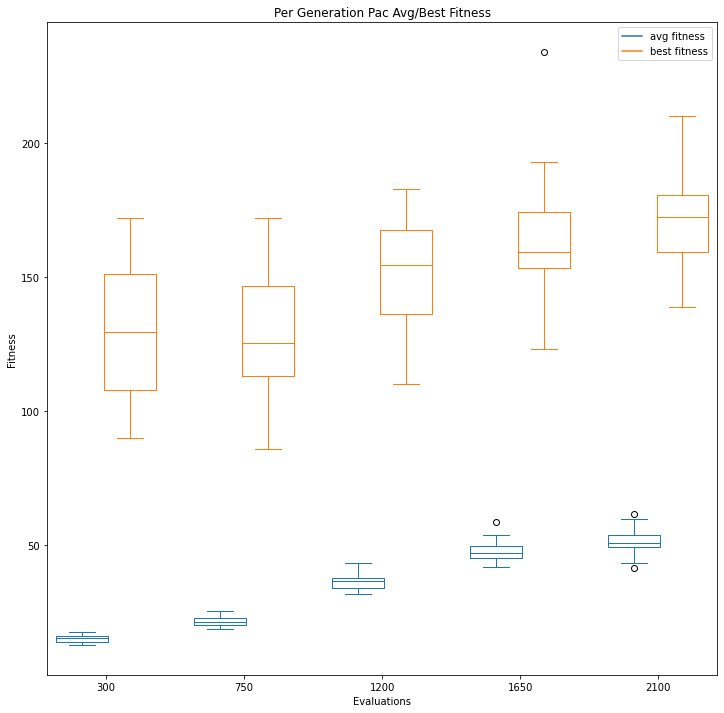

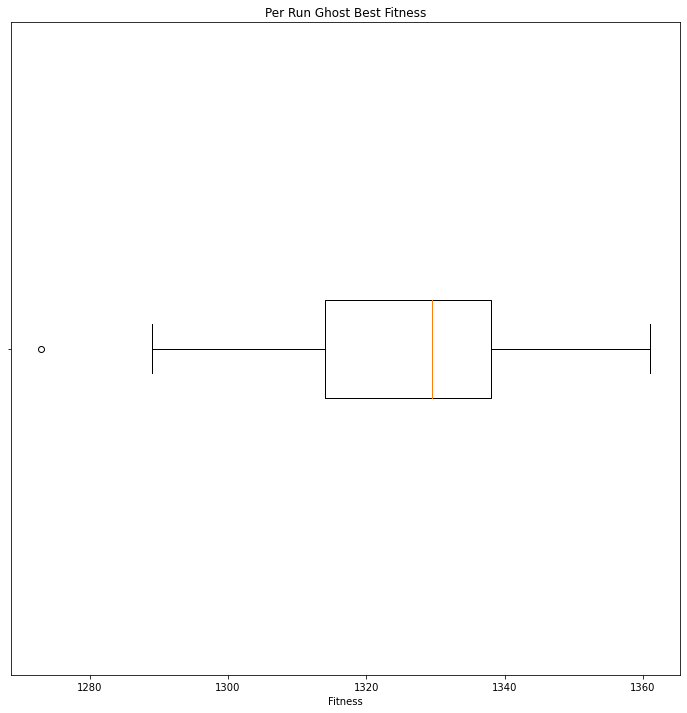

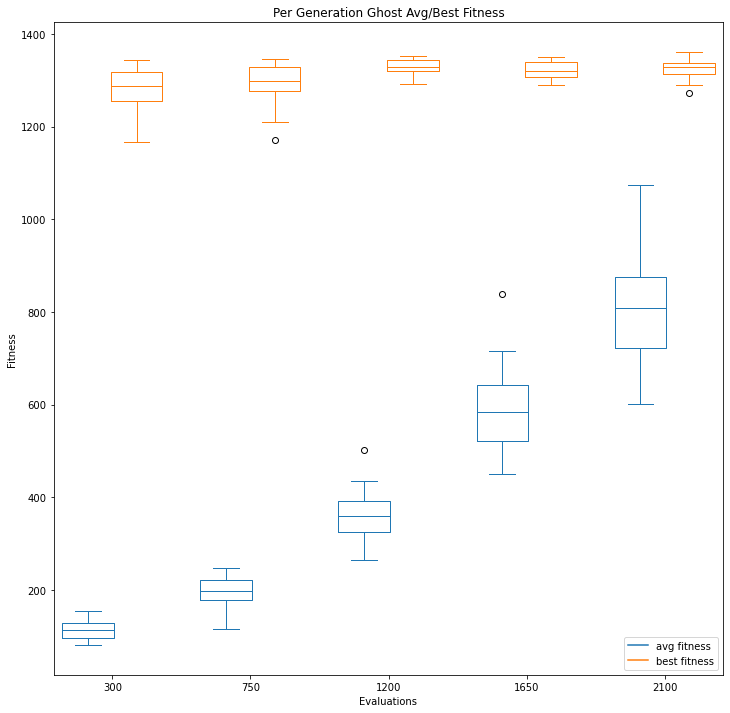

In [10]:
number_runs = 30
number_evaluations = 2000
config_filename = './configs/green2c_config.txt'

experiment(number_runs, number_evaluations, config_filename)

In [11]:
!python tree_to_latex.py solutions/pac-green2c.txt

!python tree_to_latex.py solutions/ghost-green2c.txt

V(s') = (\frac{\frac{(RAND(G,\, G) + (G + P))}{(RAND(G,\, W) + RAND(G,\, W))}}{RAND((\frac{G}{-8.733} + \frac{-3.833}{W}),\, (-5.178 + G) * (G + P))} + \frac{F * P * (P + W)}{RAND(RAND(G,\, P),\, (G + P))} * \frac{8.128}{RAND((F + G),\, RAND(W,\, F))})
V(s') = (((M + P) + ((M + G) + W * G) * RAND(P,\, W) * \frac{G}{M}) + (((M * M + \frac{M}{W}) + ((M + W) + RAND(F,\, M))) + \frac{(M + W)}{P * P} * \frac{(G + -7.943)}{RAND(\frac{F}{G},\, M)}))


## YELLOW and RED Deliverables
Feel free to create more notebook cells for YELLOW and RED deliverables as necessary. Here are some comments on those deliverables.

### Config Files
For the YELLOW and RED deliverables in this assignment, you are tasked with creating your own config files. For the YELLOW deliverable, for example, you may want to add an additional configuration parameter for how often CIAO evaluations are performed. For many of the RED deliverables, you can use the provided config files and code as inspiration for new config files and the parsing of those files, respectively.

### Modified Fitness Function
RED deliverables 2-6 require a modified version of the `play_GPac` function. See the last cell of `2b_notebook.ipynb` for more information.